## <a href="https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/projects/project-notebooks/Arctic_sea_ice_change_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/projects/project-notebooks/Arctic_sea_ice_change_2024.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Arctic Sea Ice Change

**Content creators:** Alistair Duffey, Will Gregory, Michel Tsamados

**Content reviewers:** Paul Heubel, Laura Paccini, Jenna Pearson, Ohad Zivan

**Content editors:** Paul Heubel

**Production editors:** Paul Heubel, Konstantine Tsafatinos

**Our 2024 Sponsors:** CMIP, NFDI4Earth


In [1]:
# @title Project Background

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'gt6o3lqu5zA'), ('Bilibili', 'BV12pGDeVEBw'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Slides
# @markdown These are the slides for the video introduction to the project
from IPython.display import IFrame
link_id = "y6em2"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/y6em2/


In this project, you will be given the opportunity to explore data from climate models to examine the modeled change in sea ice coverage over time.

The project aims to:
* Download, process, and plot data showing modeled sea ice coverage over the historical period within a CMIP6 model climate.
* Calculate the total sea ice extent and assess its rate of decline over the recent historical period, and project it into the future under a middle-of-the-road emissions scenario.
* Assess the dependence of future projections on emissions scenario, e.g. to assess whether any emissions scenario is sufficient to keep late-summer sea ice in the Arctic.
* Examine the spatial and seasonal variation of sea ice and how this changes during its decline with warming.

We also include a dataset of satellite observations, in case you would like to check the realism of the model's representation of sea ice in the recent historical period.


# Project Template

<img src='../template-images/2024_SeaIce.svg'/>

# Data Exploration Notebook

## Project Setup

In [3]:
# google colab installs

#!pip install --quiet cartopy xmip intake-esm


In [4]:
!pip install cmocean

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 6.3 MB/s eta 0:00:00


In [125]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import os
import cftime
import nc_time_axis
from scipy.signal import detrend
from scipy import stats

In [6]:
# @title Figure settings

#import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle")

In [126]:
# Helper functions
import os
import pooch
import tempfile

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/projects/SeaIce"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

## CESM2-WACCM: Climate model simulations of sea ice concentration

Here we use the output from [CESM2-WACCM, the Community Earth System Model (version 2, CESM2)](https://doi.org/10.1029/2019ms001916), with the [Whole Atmosphere Community Climate Model (WACCM)](https://doi.org/10.1029/2019JD030943) as its atmosphere component.

We use the historical scenario, which runs with historical forcings from 1850 to 2014. Note that this scenario is just one instance of internal variability in a world forced by historical GHGs.

A note on the sea ice output for CMIP6 models:

The Sea Ice component of models is generally output on the ocean grid, which is normally not a simple lat/lon grid, unlike many atmosphere model components. Here we use the variable ***siconca*** which stands for *sea ice concentration atmosphere* - this is the sea ice concentration re-gridded onto the model's atmosphere grid and is somewhat easier to work with.


Let's search the CMIP6 catalog for some sea ice concentration (`siconca`) data from the CESM Earth System Model. We pick a certain ensemble member (`r1i1p1f1`) to reduce the amount of data to download. At first, our scenarios of interest are the `historical` and the middle-of-the-road `ssp245` ones. As we get the data on the native grid (`gn`), we must also download the grid cell area in the next step.

*Hint: for a detailed explanation of the following `xmip` functionalities and other CMIP6 related terms, please refer to:*
* *W1D5 [Tutorial 7](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/W1D5_ClimateModeling/W1D5_Tutorial7.ipynb),*
* *W2D1 [Tutorial 1](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial1.ipynb),*
* *our [CMIP Resource bank](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md),*
* *xmip's [tutorials](https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html)*
* *[this lecture](https://earth-env-data-science.github.io/lectures/models/cmip.html) by Ryan Abernathy, Professor of Earth and Environmental Sciences at Columbia University*

In [127]:
# Code to retrieve and load the data if download from google cloud storage fails

link_id = 'bnjvp' # historical
#link_id = '4uytf' # ssp126
#link_id = '89tp2' # ssp245
#link_id = '' # ssp585

CMIP6_url = f"https://osf.io/download/{link_id}/"

siconca_fname = 'CMIP_NCAR_CESM2-WACCM_historical_r1i1p1f1_SImon_siconca_gn.nc'
#siconca_fname = 'CMIP_NCAR_CESM2-WACCM_ssp126_r1i1p1f1_SImon_siconca_gn.nc'
#siconca_fname = 'CMIP_NCAR_CESM2-WACCM_ssp245_r1i1p1f1_SImon_siconca_gn.nc'
#siconca_fname = 'CMIP_NCAR_CESM2-WACCM_ssp585_r1i1p1f1_SImon_siconca_gn.nc'
SI_ds_unmatched = xr.open_dataset(pooch_load(CMIP6_url, siconca_fname))

# Code to retrieve and load the data if download from google cloud storage fails

link_id = 'hgju4'
CMIP6_url = f"https://osf.io/download/{link_id}/"

metric_fname = 'CMIP_NCAR_CESM2-WACCM_historical_r1i1p1f1_fx_areacella_gn.nc'
SI_ds_metric = xr.open_dataset(pooch_load(CMIP6_url, metric_fname))

In [128]:
SI_ds = xr.merge([SI_ds_unmatched, SI_ds_metric], compat='override')
SI_ds

<xarray.Dataset> Size: 441MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * x               (x) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time            (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:...
    time_bounds     (time, nbnd) object 32kB ...
    lat_bounds      (y, nbnd, x) float64 885kB ...
    lon_bounds      (x, nbnd, y) float64 885kB ...
  * nbnd            (nbnd) int64 16B 0 1
    lon             (x, y) float64 442kB ...
    lat             (x, y) float64 442kB ...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Data variables:
    siconca         (member_id, dcpp_init_year, time, y, x) float32 438MB ...
    areacella       (member_id, dcpp_init_year, y, x) float32 221kB ...
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            20075.0
    case_id:                          4
    ...                               ...
    intake_esm_attrs:variable_id:     siconca
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/...
    intake_esm_attrs:version:         20190507
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2-WACCM.historical.r1i1p1...

In [10]:
SI_arctic = SI_ds.sel(y = slice(55, 90)).groupby('time.year').mean()

Text(0.5, 1.0, 'Sea Ice Concentration | 1850')

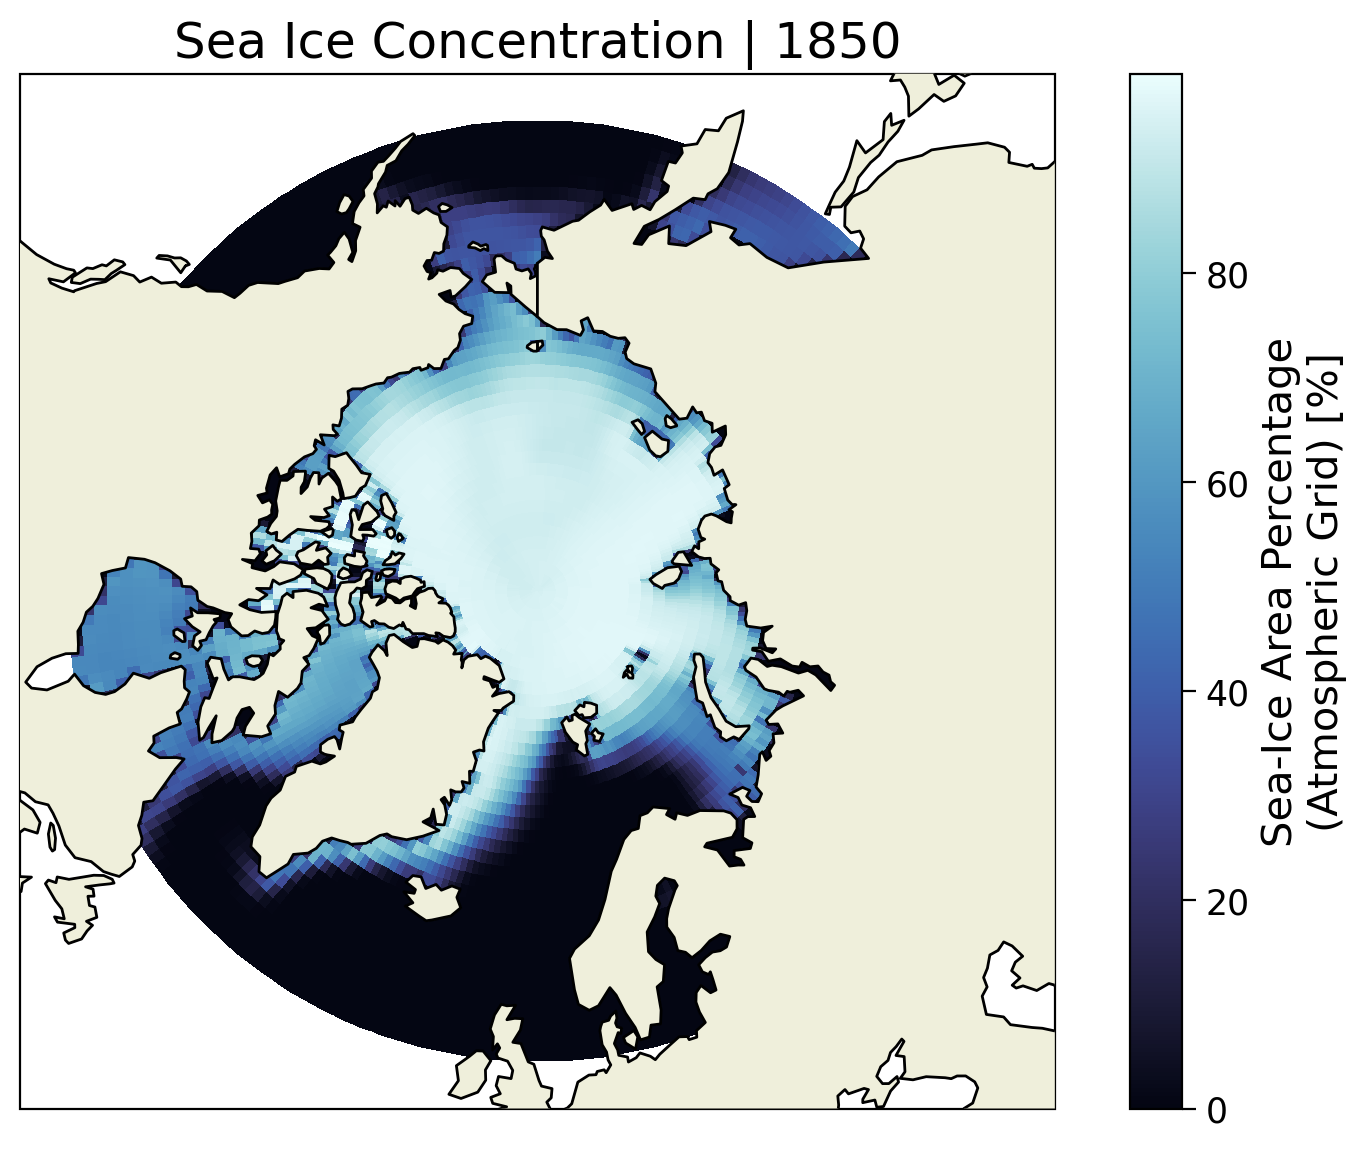

In [11]:
# plot Sea Surface Temprature - similar to plots we used in tutorials 2+3
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.NorthPolarStereo()}, dpi=100
)

SI_arctic.siconca.isel(year = 0).plot(
    ax=ax,
    transform = ccrs.PlateCarree(),
    cmap = cmocean.cm.ice
)

ax.coastlines(color="grey", lw=0.5)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor="k")

ax.set_title("Sea Ice Concentration | 1850")

Text(0.5, 1.0, 'Sea Ice Concentration | 1950')

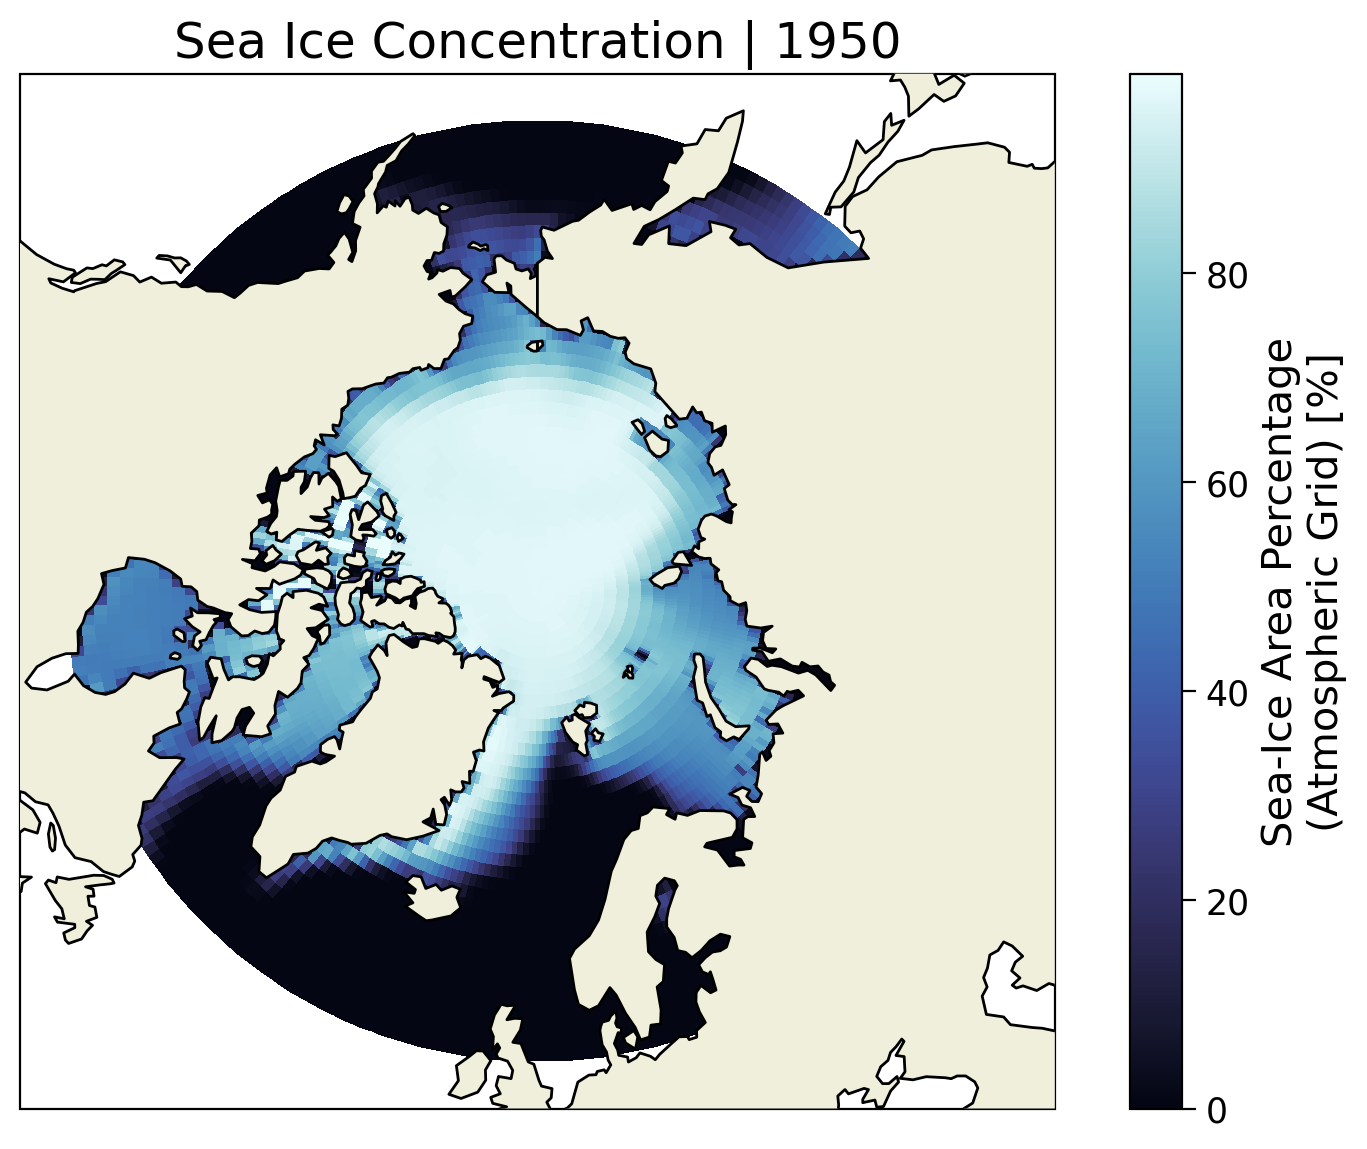

In [12]:
# plot Sea Surface Temprature - similar to plots we used in tutorials 2+3
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.NorthPolarStereo()}, dpi=100
)

SI_arctic.siconca.isel(year = 99).plot(
    ax=ax,
    transform = ccrs.PlateCarree(),
    cmap = cmocean.cm.ice
)

ax.coastlines(color="grey", lw=0.5)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor="k")

ax.set_title("Sea Ice Concentration | 1950")

Text(0.5, 1.0, 'Sea Ice Concentration | 2014')

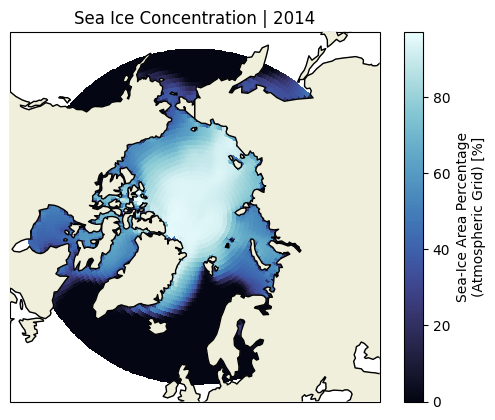

In [12]:
# plot Sea Surface Temprature - similar to plots we used in tutorials 2+3
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.NorthPolarStereo()}, dpi=100
)

SI_arctic.siconca.isel(year = -1).plot(
    ax=ax,
    transform = ccrs.PlateCarree(),
    cmap = cmocean.cm.ice
)

ax.coastlines(color="grey", lw=0.5)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor="k")

ax.set_title("Sea Ice Concentration | 2014")

In [13]:
SIE = SI_ds.sel(y = slice(55, 90)).where(SI_ds.siconca > 15)
areas_arctic = SIE.areacella.sum(dim=['x','y'])
areas_arctic

<xarray.DataArray 'areacella' (member_id: 1, dcpp_init_year: 1, time: 1980)> Size: 8kB
array([[[1.5540189e+13, 1.5800736e+13, 1.5950444e+13, ...,
         7.1396617e+12, 1.0367093e+13, 1.2339276e+13]]], dtype=float32)
Coordinates:
  * time            (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan

Text(0.5, 0, 'Time [year]')

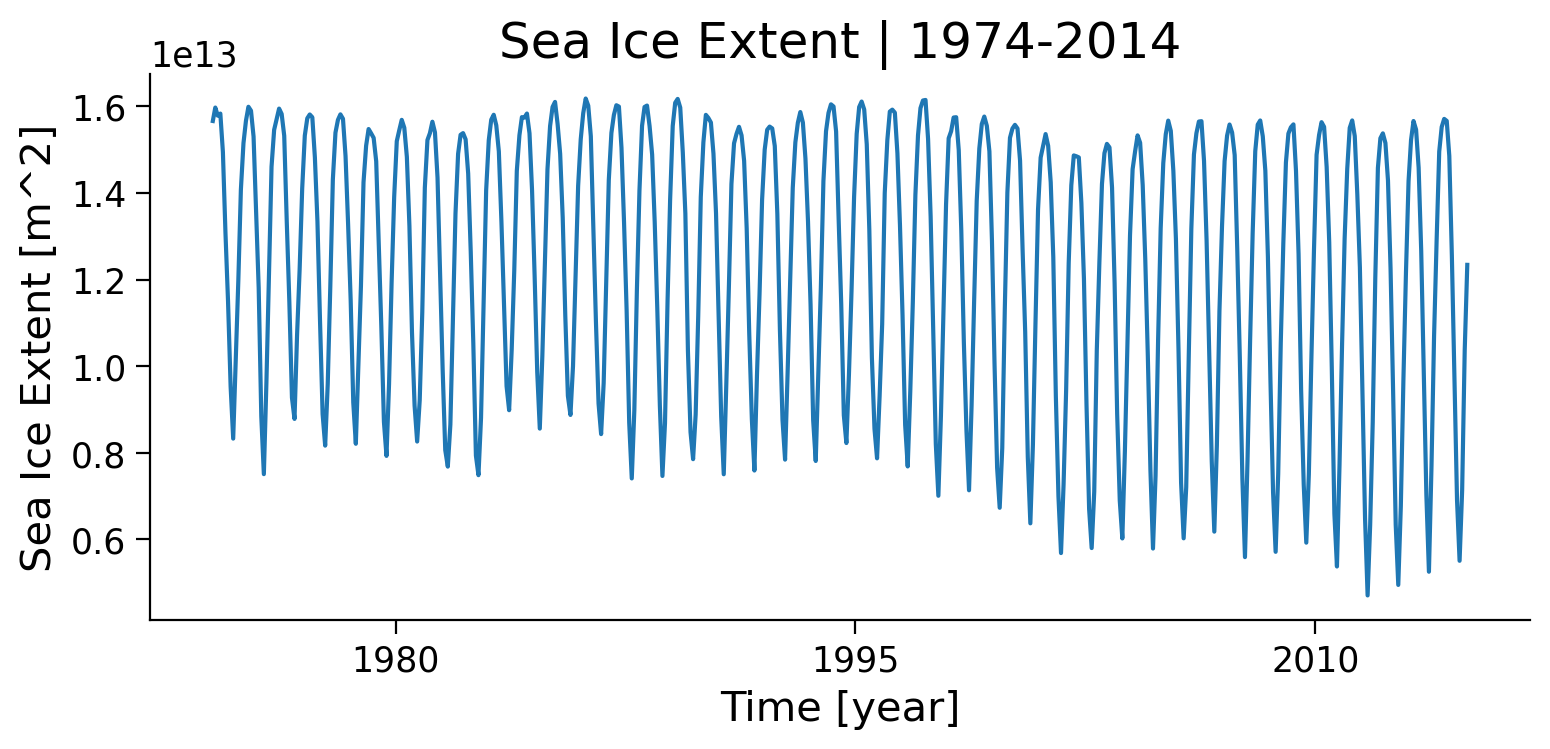

In [14]:
plt.figure(figsize = (8,4))

areas_arctic.sel(time = slice('1974-01-01', '2014-12-31')).plot()

plt.title('Sea Ice Extent | 1974-2014')
plt.ylabel('Sea Ice Extent [m^2]')
plt.xlabel('Time [year]')

In [16]:
areas_arctic_seasons = areas_arctic.groupby('time.season')
areas_arctic_seasons

DataArrayGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [17]:
SI_antarctic = SI_ds.sel(y = slice(-90, -55)).groupby('time.year').mean()

Text(0.5, 1.0, 'Sea Ice Concentration | 1850')

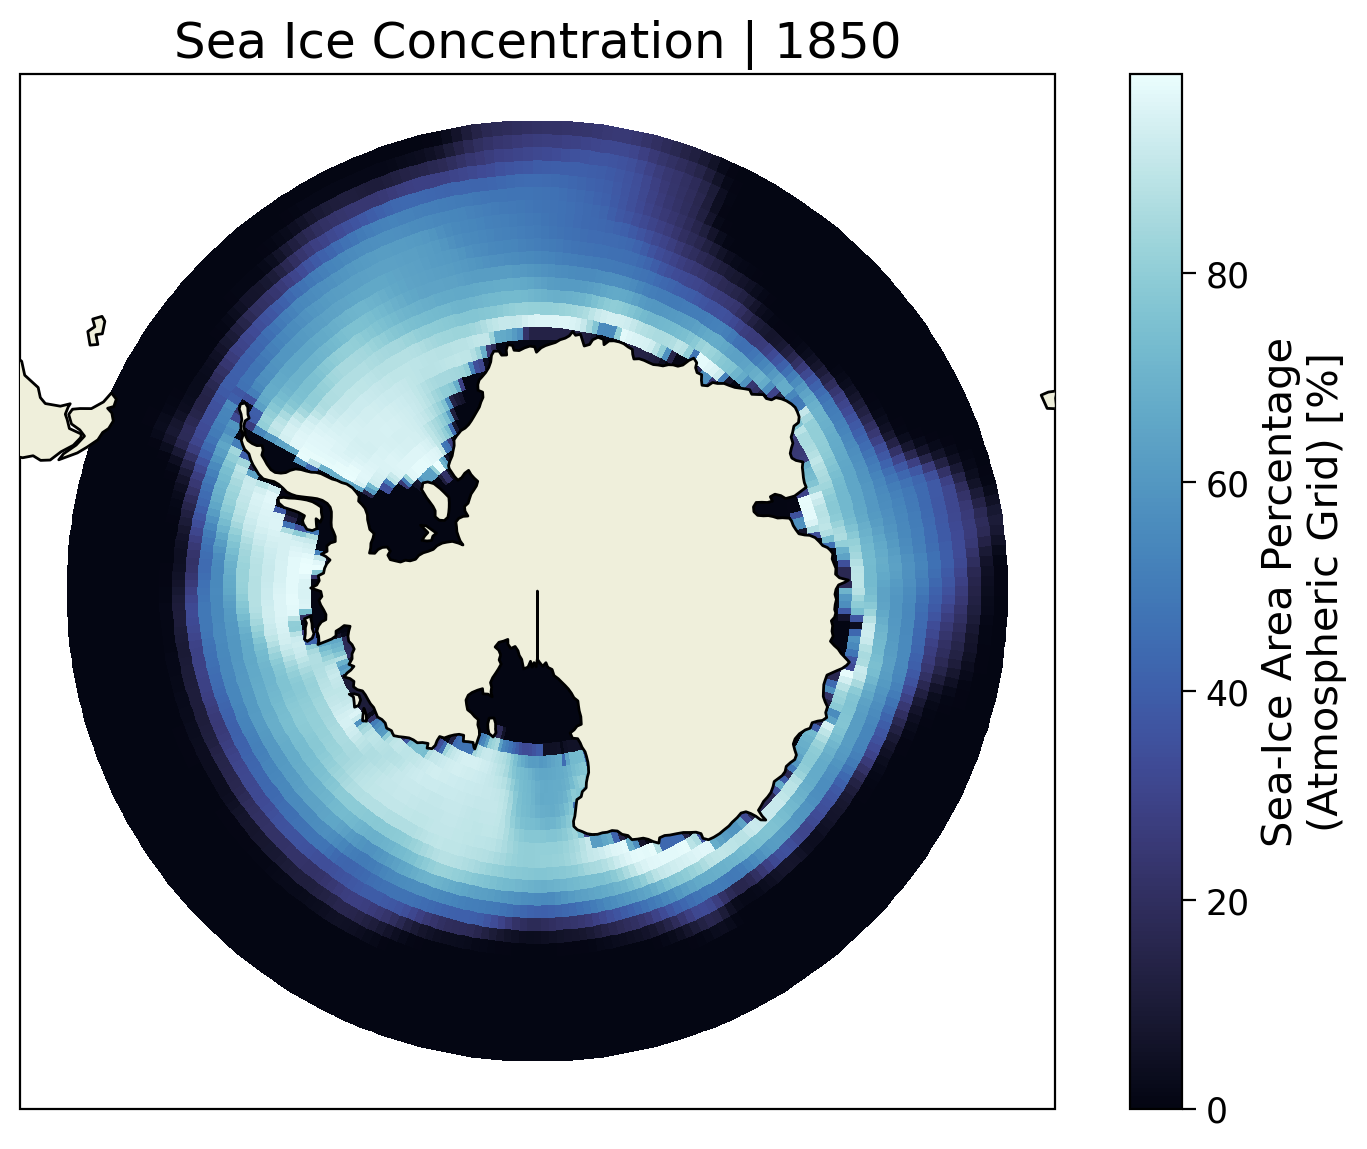

In [18]:
# plot Sea Surface Temprature - similar to plots we used in tutorials 2+3
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.SouthPolarStereo()}, dpi=100
)

SI_antarctic.siconca.isel(year = 0).plot(
    ax=ax,
    transform = ccrs.PlateCarree(),
    cmap = cmocean.cm.ice
)

ax.coastlines(color="grey", lw=0.5)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor="k")

ax.set_title("Sea Ice Concentration | 1850")

Text(0.5, 1.0, 'Sea Ice Concentration | 1950')

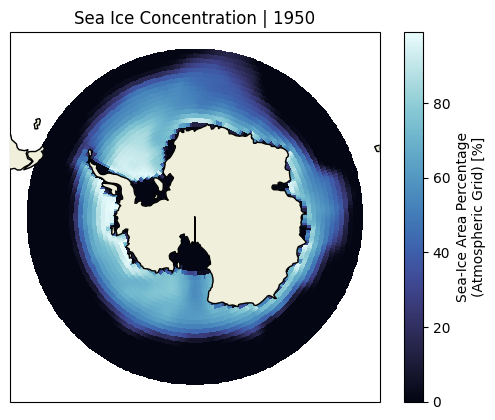

In [29]:
# plot Sea Surface Temprature - similar to plots we used in tutorials 2+3
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.SouthPolarStereo()}, dpi=100
)

SI_antarctic.siconca.isel(year = 99).plot(
    ax=ax,
    transform = ccrs.PlateCarree(),
    cmap = cmocean.cm.ice
)

ax.coastlines(color="grey", lw=0.5)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor="k")

ax.set_title("Sea Ice Concentration | 1950")

Text(0.5, 1.0, 'Sea Ice Concentration | 2014')

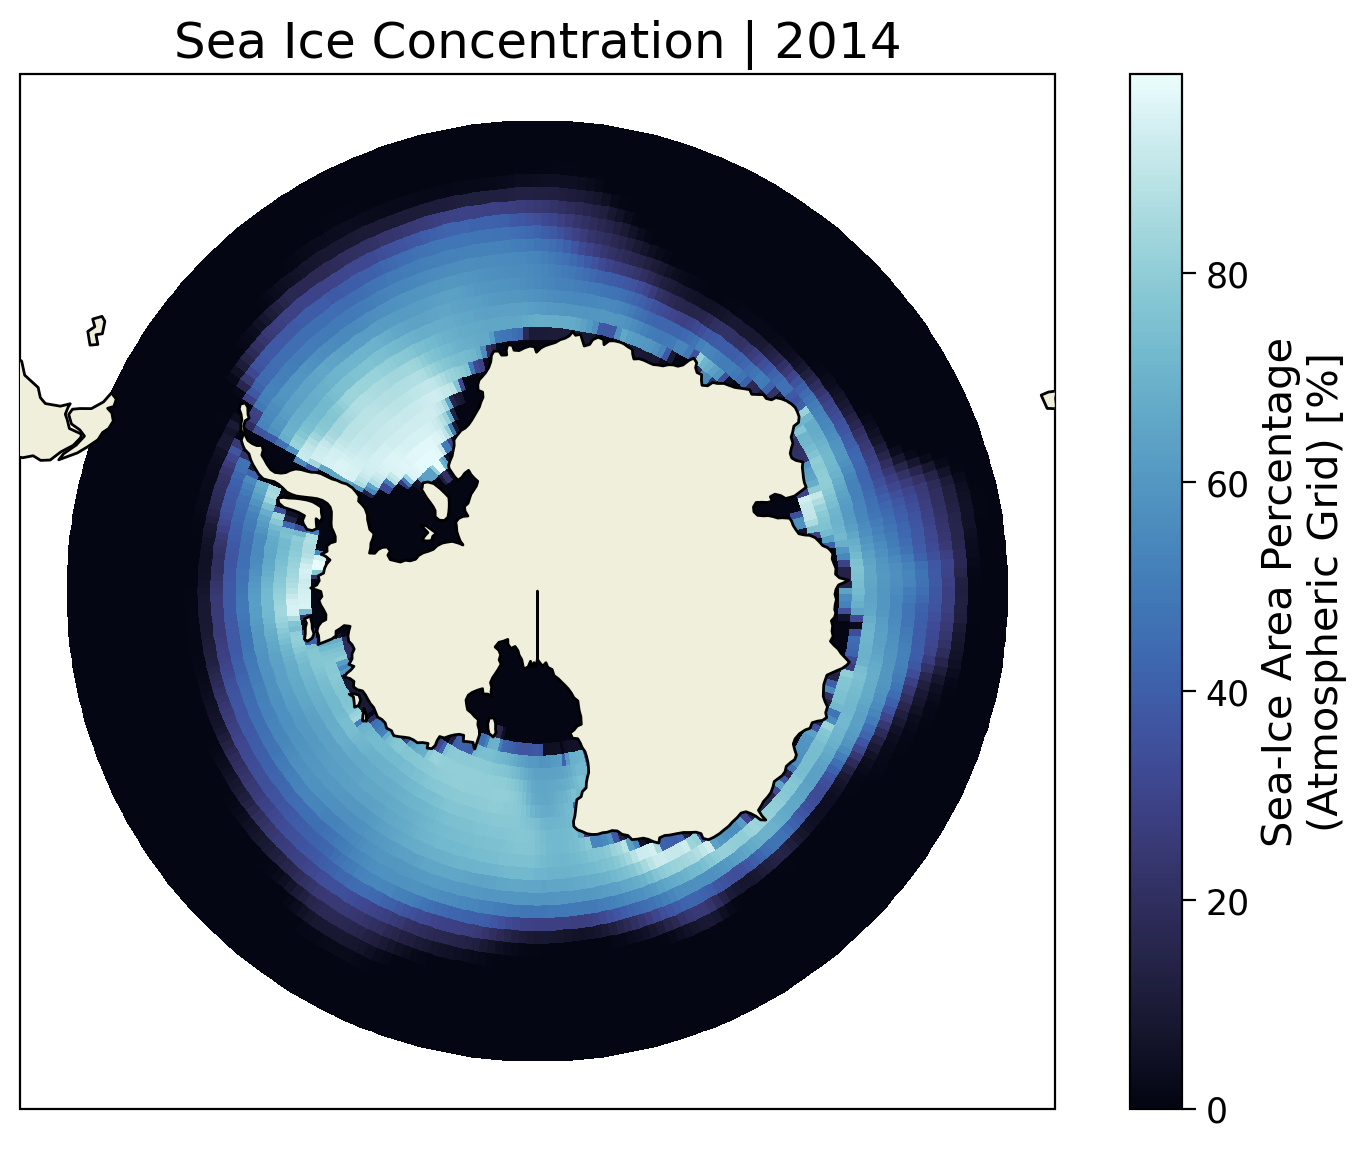

In [19]:
# plot Sea Surface Temprature - similar to plots we used in tutorials 2+3
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.SouthPolarStereo()}, dpi=100
)

SI_antarctic.siconca.isel(year = -1).plot(
    ax=ax,
    transform = ccrs.PlateCarree(),
    cmap = cmocean.cm.ice
)

ax.coastlines(color="grey", lw=0.5)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor="k")

ax.set_title("Sea Ice Concentration | 2014")

In [23]:
SIE2 = SI_ds.sel(y = slice(-90, -55)).where(SI_ds.siconca > 15)
areas_antarctic = SIE2.areacella.sum(dim=['x','y'])
areas_antarctic

<xarray.DataArray 'areacella' (member_id: 1, dcpp_init_year: 1, time: 1980)> Size: 8kB
array([[[1.0396527e+13, 6.9812119e+12, 7.4432465e+12, ...,
         1.7100657e+13, 1.6551432e+13, 1.4384098e+13]]], dtype=float32)
Coordinates:
  * time            (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan

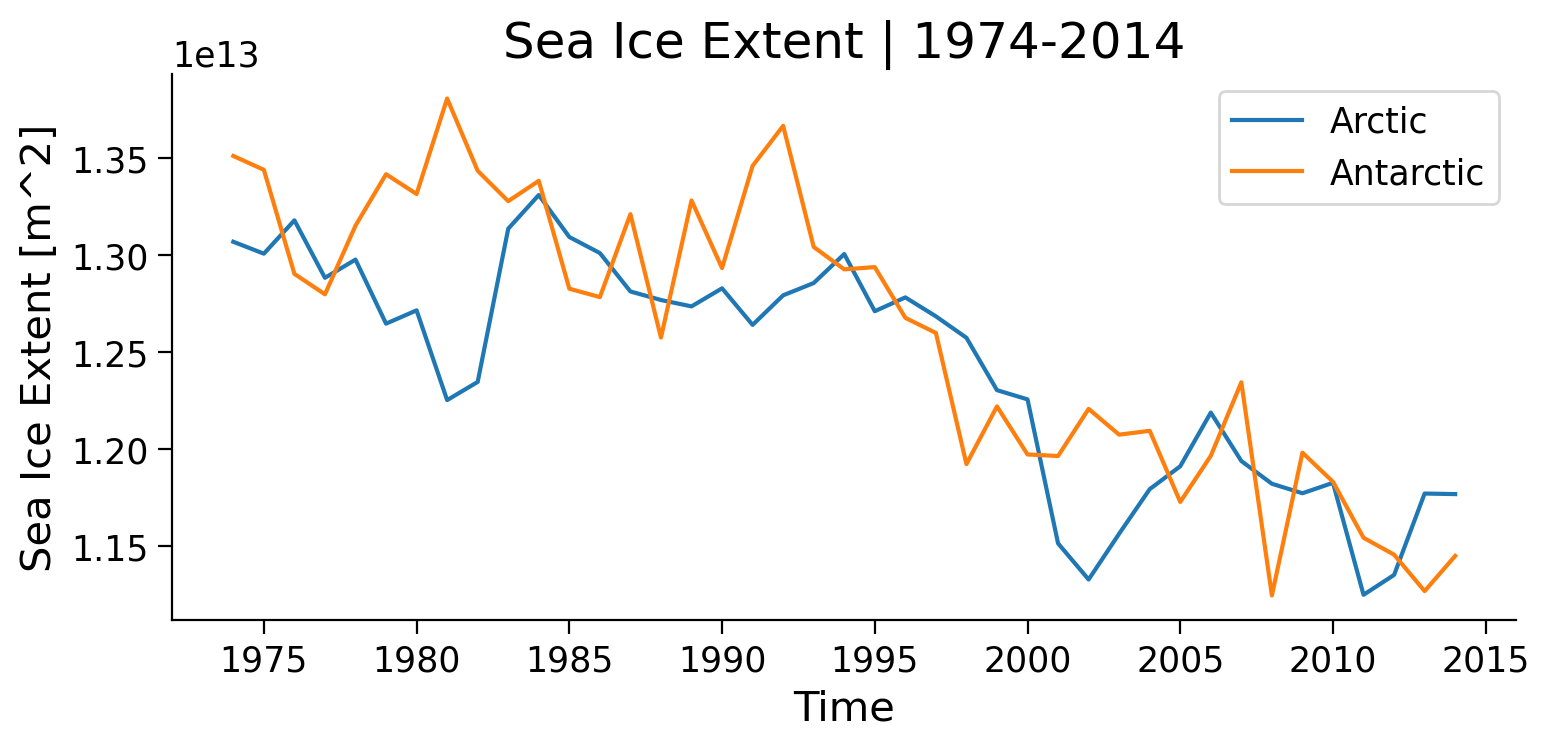

In [24]:
plt.figure(figsize = (8,4))

areas_arctic.sel(time = slice('1974-01-01', '2014-12-31')).groupby('time.year').mean().plot(label = 'Arctic')
areas_antarctic.sel(time = slice('1974-01-01', '2014-12-31')).groupby('time.year').mean().plot(label = 'Antarctic')

plt.title('Sea Ice Extent | 1974-2014')
plt.ylabel('Sea Ice Extent [m^2]')
plt.xlabel('Time')
plt.legend()

# plt.savefig('SIE_time_series.png', bbox_inches='tight')

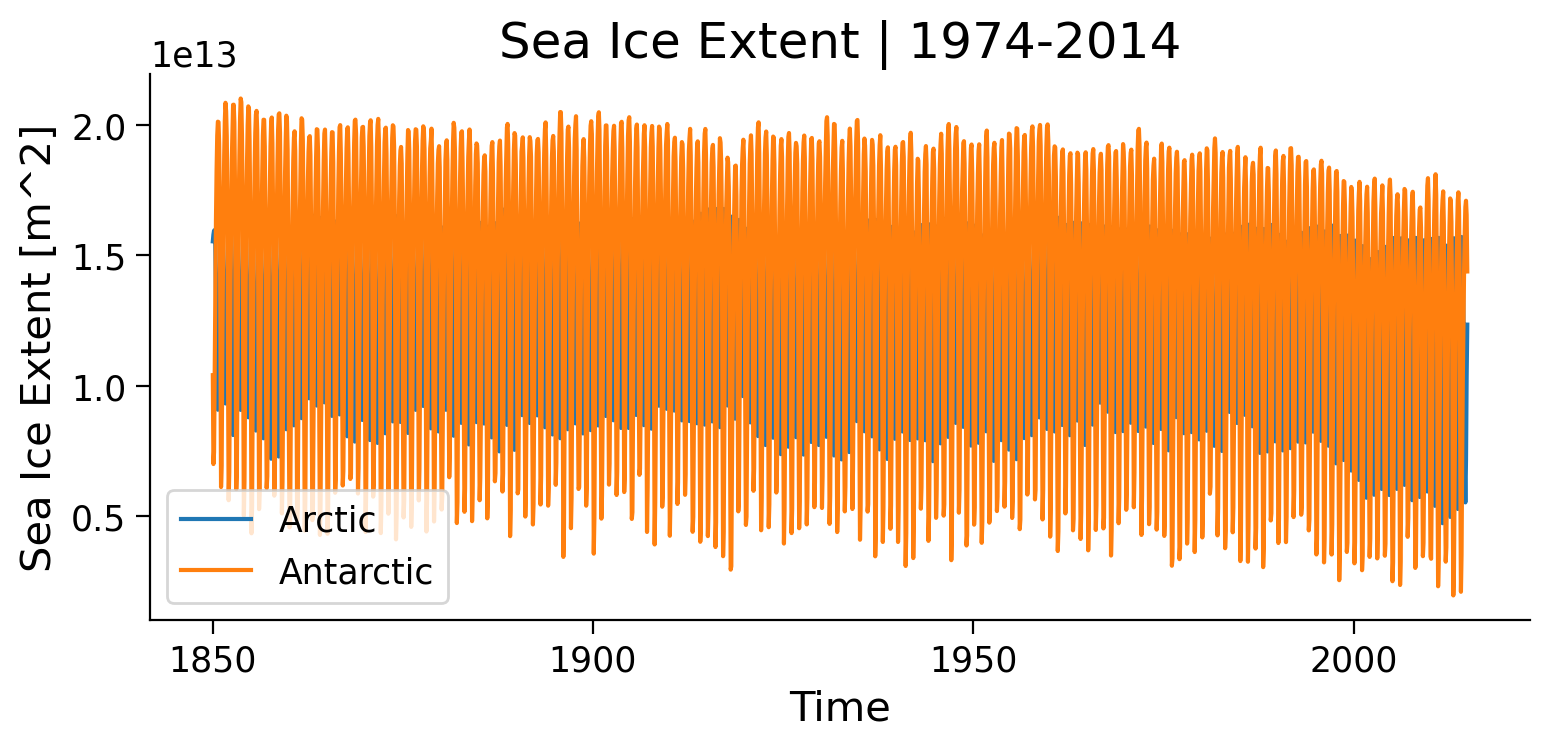

In [26]:
plt.figure(figsize = (8,4))

areas_arctic.plot(label = 'Arctic')
areas_antarctic.plot(label = 'Antarctic')

plt.title('Sea Ice Extent | 1974-2014')
plt.ylabel('Sea Ice Extent [m^2]')
plt.xlabel('Time')
plt.legend()

In [129]:
# download the monthly sea surface temperature data from NOAA Physical System
# Laboratory. The data is processed using the OISST SST Climate Data Records
# from the NOAA CDR program.
# the data downloading may take 2-3 minutes to complete.
# filename=sst.mon.mean.nc
url_sst = "https://osf.io/6pgc2/download/"
filename = "sst.mon.mean.nc"

# we divide the data into small chunks to allow for easier memory manangement. this is all done automatically, no need for you to do anything
ds = xr.open_dataset(
pooch_load(filelocation=url_sst, filename=filename),
chunks={"time": 25, "latitude": 200, "longitude": 200},
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 499, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 2GB dask.array<chunksize=(25, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [130]:
# Slicing SST data in the Nino 3.4 region
ds_ENSO=ds.sel(time= slice('1981-09-01','2014-12-31'), lat=slice(-5, 5), lon=slice(190, 240))

# Slicing SI data for the time period
SI_ds2 = SI_ds.sel(time= slice('1981-09-01','2014-12-31'))

In [131]:
# SIE Calculation
SIE_2 = SI_ds2.where(SI_ds2.siconca > 15)

SIE_arctic = SIE_2.sel(y= slice(55,90))
SIE_antarctic = SIE_2.sel(y = slice(-90,-55))

SIE_glob = SIE_2.areacella.sum(dim = ['x','y'])
SIE_arctic = SIE_arctic.areacella.sum(dim = ['x','y'])
SIE_antarctic = SIE_antarctic.areacella.sum(dim = ['x','y'])

In [132]:
# Climatology Calculation
ENSO_clim = ds_ENSO.groupby('time.month').mean(dim = 'time')

SIE_glob_clim = SIE_glob.groupby('time.month').mean(dim = 'time')
SIE_arctic_clim = SIE_arctic.groupby('time.month').mean(dim = 'time')
SIE_antarctic_clim = SIE_antarctic.groupby('time.month').mean(dim = 'time')

In [133]:
# Anomaly Calculation
ENSO_anom = ds_ENSO.groupby('time.month') - ENSO_clim

SIE_glob_anom = SIE_glob.groupby('time.month') - SIE_glob_clim
SIE_arctic_anom = SIE_arctic.groupby('time.month') - SIE_arctic_clim
SIE_antarctic_anom = SIE_antarctic.groupby('time.month') - SIE_antarctic_clim

In [134]:
ONI = ENSO_anom.sst.mean(dim=['lat','lon'])
nino1 = ONI.sel(time = slice('1996','2000')).where(ONI > 0.5)

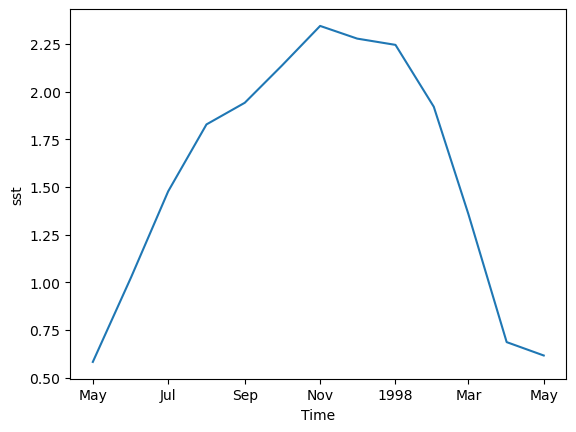

In [78]:
nino1.plot()

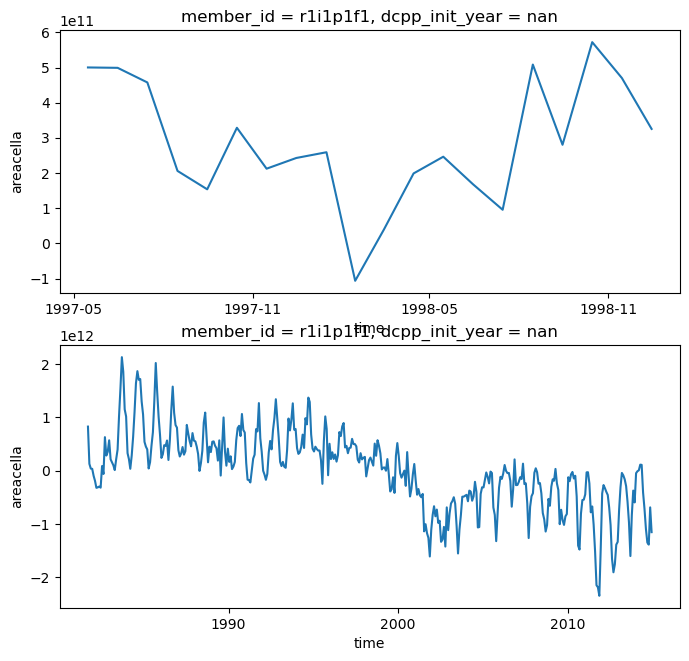

In [86]:
fig , ax = plt.subplots(nrows = 2, ncols =1, figsize = (8, 7.5))

SIE_arctic_anom.sel(time= slice ('1997-05','1998-12')).plot(ax=ax[0])
SIE_arctic_anom.plot(ax=ax[1])

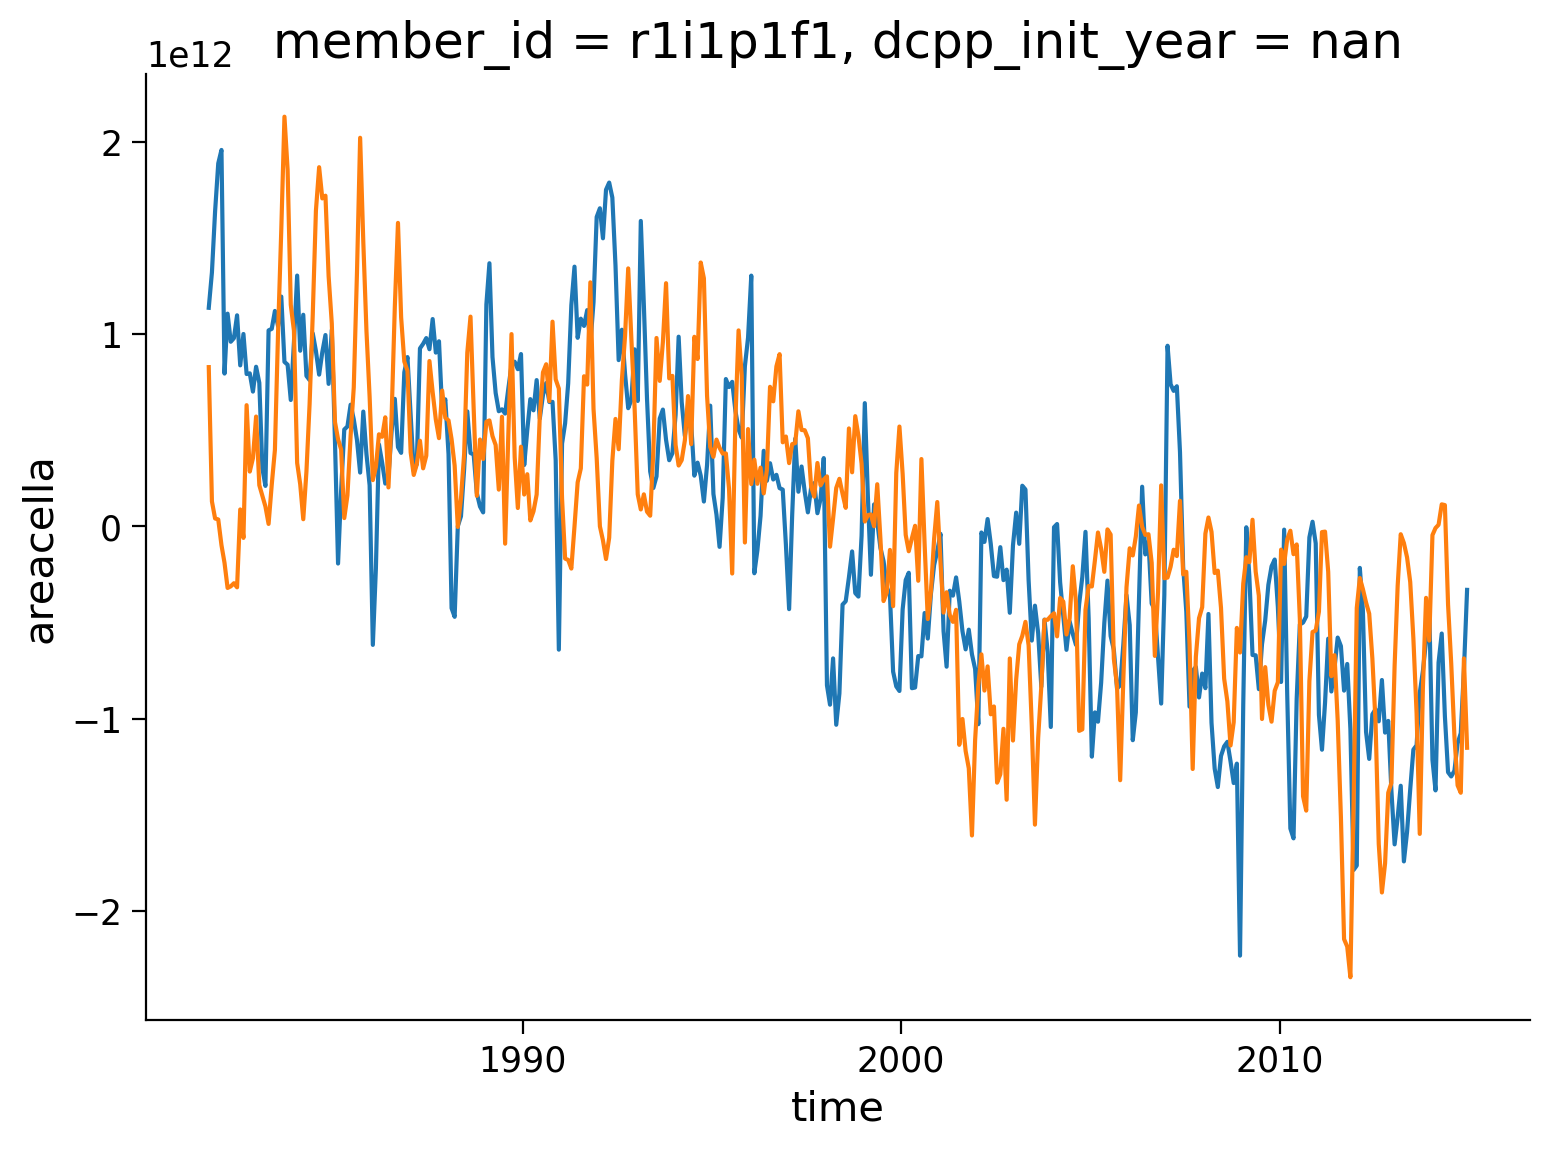

In [79]:
SIE_antarctic_anom.plot()
SIE_arctic_anom.plot()

In [135]:
#print(SIE_arctic_anom)
def cftime_to_datetime64(cftime_dates): 
    return np.array([np.datetime64(date.strftime('%Y-%m-%d')) for date in cftime_dates]) 

new_time = cftime_to_datetime64(SIE_arctic_anom.coords['time'].values)
SIE_arctic_anom.coords['time'] = ('time', new_time)


/tmp/ipykernel_429/1809435452.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  SIE_arctic_anom.coords['time'] = ('time', new_time)


<xarray.DataArray 'areacella' (member_id: 1, dcpp_init_year: 1, time: 400)> Size: 2kB
array([[[ 8.27075854e+11,  1.28918749e+11,  4.01740923e+10,
          3.50297784e+10, -9.83595745e+10, -1.90706614e+11,
         -3.21083408e+11, -3.12703189e+11, -2.96510030e+11,
         -3.17779345e+11,  8.70601196e+10, -6.08551567e+10,
          6.29226340e+11,  2.84028305e+11,  3.53534738e+11,
          5.70039468e+11,  2.13401993e+11,  1.58427251e+11,
          1.02546538e+11,  1.18289859e+10,  2.16076911e+11,
          3.96788498e+11,  1.01033758e+12,  1.54311066e+12,
          2.12908900e+12,  1.85305347e+12,  1.15084467e+12,
          1.01681254e+12,  3.28821899e+11,  2.18137362e+11,
          3.63090412e+10,  2.83592622e+11,  6.34612875e+11,
          1.09935120e+12,  1.64042690e+12,  1.86647786e+12,
          1.70425215e+12,  1.71833976e+12,  1.30001509e+12,
          1.05499224e+12,  5.40956164e+11,  4.52248732e+11,
          3.99403647e+11,  4.21915525e+10,  1.60152158e+11,
          4.68689355e+11,  7.21550311e+11,  1.31788177e+12,
          2.01944885e+12,  1.47829765e+12,  1.01503939e+12,
          6.72097370e+11,  2.39588082e+11,  3.07570409e+11,
          4.77690331e+11,  4.64885121e+11,  5.66087385e+11,
          2.01430401e+11,  5.71027227e+11,  1.14102475e+12,
...
         -6.83912724e+10, -2.35373855e+10, -1.45594778e+11,
         -9.48856422e+10, -4.82159362e+11, -1.40442757e+12,
         -1.47875902e+12, -8.05372953e+11, -5.50065144e+11,
         -5.42720918e+11, -4.44455715e+11, -3.06708480e+10,
         -2.82045972e+10, -2.37503513e+11, -7.79770397e+11,
         -6.70536040e+11, -1.01060706e+12, -1.51189035e+12,
         -2.14687390e+12, -2.18588093e+12, -2.34511401e+12,
         -1.44658399e+12, -4.24752972e+11, -2.69262782e+11,
         -3.26900908e+11, -3.96636455e+11, -4.54998098e+11,
         -6.88445719e+11, -1.01813060e+12, -1.65250335e+12,
         -1.90430681e+12, -1.75337583e+12, -1.38602139e+12,
         -1.33491799e+12, -7.25769781e+11, -3.09318386e+11,
         -4.17805107e+10, -8.75760189e+10, -1.61855046e+11,
         -2.89867301e+11, -5.83636353e+11, -9.72171510e+11,
         -1.59984281e+12, -8.36535583e+11, -3.72577927e+11,
         -5.94502746e+11, -4.63030190e+10, -9.56930458e+09,
          7.39036365e+09,  1.13557635e+11,  1.09775421e+11,
         -4.07358145e+11, -7.13804481e+11, -1.09281280e+12,
         -1.34733260e+12, -1.38580591e+12, -6.87395045e+11,
         -1.15202746e+12]]], dtype=float32)
Coordinates:
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    month           (time) int64 3kB 9 10 11 12 1 2 3 4 5 ... 5 6 7 8 9 10 11 12
  * time            (time) datetime64[ns] 3kB 1981-09-15 ... 2014-12-15

In [145]:
def cftime_to_datetime64(cftime_dates): 
    return np.array([np.datetime64(date.strftime('%Y-%m-%d')) for date in cftime_dates]) 

new_time = cftime_to_datetime64(SIE_antarctic_anom.coords['time'].values)
SIE_antarctic_anom.coords['time'] = ('time', new_time)


/tmp/ipykernel_429/3717074091.py:5: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  SIE_antarctic_anom.coords['time'] = ('time', new_time)


In [146]:
SIE_t = SIE_arctic_anom/1e12
SIE_ant_t = SIE_antarctic_anom/1e12

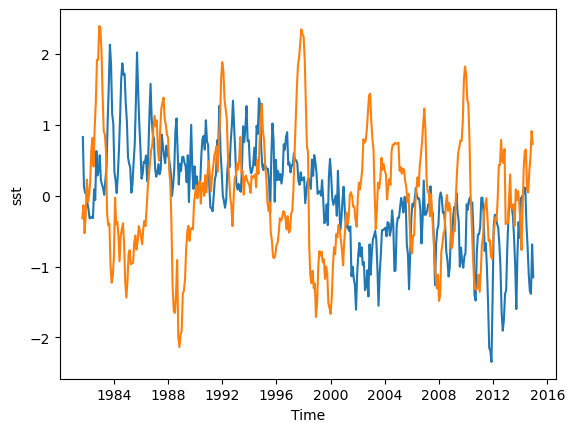

In [92]:
SIE_t.plot()
ENSO_anom.sst.mean(dim=['lat','lon']).plot()

In [147]:
oni = ENSO_anom.sst.mean(dim=['lat','lon'])
SIE = SIE_t.squeeze()
SIE_ant = SIE_ant_t.squeeze()

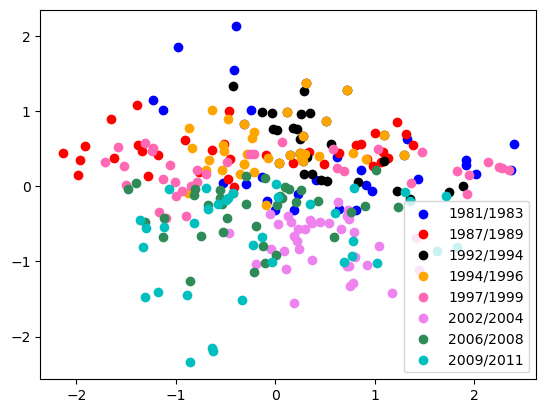

In [141]:
colors = ['b','r','k','orange','hotpink','violet','seagreen','c']
elnino_events = ['1981/1983',
                 '1987/1989',
                 '1992/1994',
                 '1994/1996',
                 '1997/1999',
                 '2002/2004',
                 '2006/2008',
                 '2009/2011']
for i in range(8):
    years = elnino_events[i].split(sep='/')
    start, end = years[0], years[1]
    plt.scatter(ENSO_anom.sst.sel(time = slice(start, end)).mean(dim=['lat','lon']), SIE_t.sel(time = slice(start, end)), 
                color = colors[i], 
                label = elnino_events[i] 
               )
plt.legend()

In [149]:
r_list = []
p_list = []

def get_corr(t0,t1):
    r, p = stats.pearsonr(oni.sel(time = slice(t0, t1)),SIE.sel(time = slice(t0, t1)))
    r_list.append(r)
    p_list.append(p)

elnino_events = ['1981/1983',
                 '1987/1989',
                 '1992/1994',
                 '1994/1996',
                 '1997/1999',
                 '2002/2004',
                 '2006/2008',
                 '2009/2011']
for event in elnino_events:
    years = event.split(sep='/')
    start, end = years[0], years[1]
    get_corr(start, end)

In [150]:
print(r_list,p_list)

[-0.4020681181647813, 0.055816142186866646, -0.5842416249962709, 0.19463072069666348, 0.12132124185786075, -0.22378391223273347, 0.11447836747940239, 0.23313225618823322] [0.033923128988497635, 0.746445377151767, 0.00018314472054077, 0.25533336431605824, 0.48090491324822326, 0.18951020238851748, 0.5061654231689692, 0.17119659040099677]


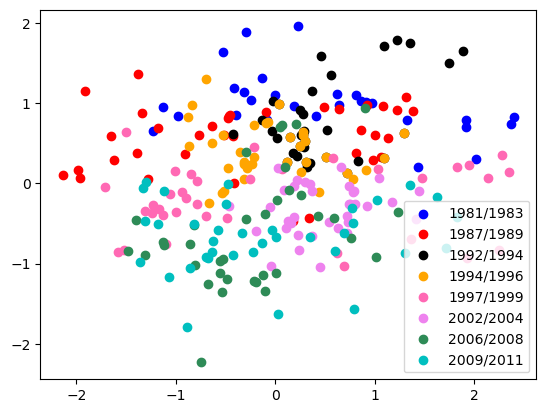

In [151]:
colors = ['b','r','k','orange','hotpink','violet','seagreen','c']
elnino_events = ['1981/1983',
                 '1987/1989',
                 '1992/1994',
                 '1994/1996',
                 '1997/1999',
                 '2002/2004',
                 '2006/2008',
                 '2009/2011']
for i in range(8):
    years = elnino_events[i].split(sep='/')
    start, end = years[0], years[1]
    plt.scatter(oni.sel(time = slice(start, end)), SIE_ant.sel(time = slice(start, end)), 
                color = colors[i], 
                label = elnino_events[i] 
               )
plt.legend()

In [156]:
r_list_ant = []
p_list_ant = []

def get_corr(t0,t1):
    r, p = stats.pearsonr(oni.sel(time = slice(t0, t1)),SIE_ant.sel(time = slice(t0, t1)))
    r_list_ant.append(r)
    p_list_ant.append(p)

elnino_events = ['1981/1983',
                 '1987/1989',
                 '1992/1994',
                 '1994/1996',
                 '1997/1999',
                 '2002/2004',
                 '2006/2008',
                 '2009/2011']
for event in elnino_events:
    years = event.split(sep='/')
    start, end = years[0], years[1]
    get_corr(start, end)

In [157]:
print(r_list_ant, p_list_ant)

[-0.4163110423791669, 0.1755691695509001, 0.5159856692775956, -0.16080571508619132, 0.09975909539034722, 0.19634437241701355, 0.4006881515294129, 0.07760313283060583] [0.027551888174091828, 0.3057307523802314, 0.0012767082573816278, 0.34880981579056114, 0.5626717179275049, 0.25109054263140534, 0.015447074041004217, 0.6528072187715288]


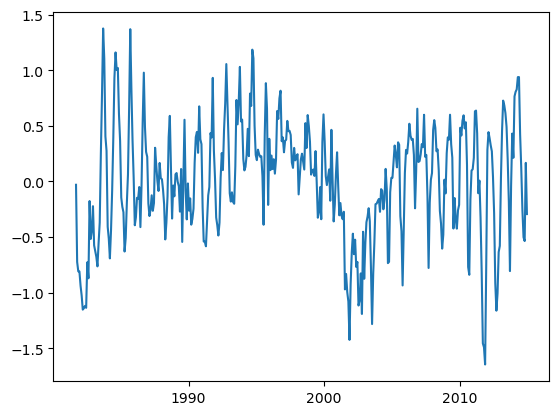

In [18]:
SIE_new = detrend(SIE_t.data,type = 'linear')
plt.plot(SIE_arctic_anom.time, SIE_new.squeeze())


In [103]:
np.corrcoef(ENSO_anom.sst.mean(dim=['lat','lon']),SIE_t)

type: y has more than 2 dimensions

In [53]:
r, p = stats.pearsonr(SIE_new[0][0], ENSO_anom.sst.values[0][0])



type: x and y must have the same length.

array([[[-0.6657734 , -0.67635155, -0.6888523 , ...,  0.28155708,
          0.3020897 ,  0.3080387 ],
        [-0.67829514, -0.7006836 , -0.6769314 , ...,  0.31092262,
          0.32431412,  0.32191277],
        [-0.7092819 , -0.6957245 , -0.66249084, ...,  0.32715607,
          0.34747124,  0.35624504],
        ...,
        [-0.3095379 , -0.29051208, -0.31498146, ...,  0.32659912,
          0.37486267,  0.3360691 ],
        [-0.39939117, -0.32281303, -0.30617714, ...,  0.4264412 ,
          0.43522453,  0.36383057],
        [-0.46687126, -0.36413765, -0.27567482, ...,  0.41300964,
          0.37913513,  0.28598022]],

       [[-0.5546398 , -0.4702263 , -0.42298126, ..., -0.11569214,
         -0.0680542 , -0.02871704],
        [-0.560009  , -0.48932648, -0.43050385, ..., -0.13921928,
         -0.10434532, -0.08502769],
        [-0.51218224, -0.4774952 , -0.42708015, ..., -0.14205742,
         -0.14496231, -0.1431694 ],
        ...,
        [-0.39266777, -0.40307236, -0.4083786 , ..., -

In [ ]:
# create a collection object from the Google Cloud Storage
col = google_cmip_col()

# search via keys
cat = col.search(
        source_id=["CESM2-WACCM"],
        variable_id=["siconca"],
        member_id="r1i1p1f1",
        #table_id="SImon",
        grid_label="gn",
        experiment_id=["historical", "ssp245"],
    #, "ssp126",  "ssp585"],
        require_all_on=["experiment_id", "variable_id"]
)
# key word arguments that allow efficient and useful preprocessing
kwargs = {'zarr_kwargs':{
    'consolidated':True,
    'use_cftime':True
},
          'aggregate':False,
          'preprocess':combined_preprocessing
}

# create a dictionary of the datasets from the catalog entries
ds_dict = cat.to_dataset_dict(**kwargs)
list(ds_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



KeyboardInterrupt

_request out of retries on exception: Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Compute Engine Metadata server unavailable
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/google/auth/compute_engine/credentials.py", line 115, in refresh
    self._retrieve_info(request)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/google/auth/compute_engine/credentials.py", line 88, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/google/auth/compute_engine/_metadata.py", line 287, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/google/auth/compute_engine/_metadata.py", line 216, in get
    raise exceptions.TransportEr

In [ ]:
# repeat the procedure with the grid cell area
cat_metric = col.search(
    source_id=['CESM2-WACCM'],
    variable_id='areacella',
    member_id="r1i1p1f1",
    experiment_id=["historical", "ssp245"]
)
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)

list(ddict_metrics.keys())

In [ ]:
#ddict_metrics[CMIP.NCAR.CESM2-WACCM.historical.r1i1p1f1.fx.areacella.gn.gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/fx/areacella/gn/v20190227/.20190227']
ddict_metrics[list(ddict_metrics.keys())[0]]

In [ ]:
# add the grid cell area metric to both scenario data sets
ddict_matched = match_metrics(ds_dict, ddict_metrics, ['areacella'])
list(ddict_matched.keys())

['ScenarioMIP.NCAR.CESM2-WACCM.ssp245.r1i1p1f1.SImon.siconca.gn.gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/SImon/siconca/gn/v20190815/.20190815',
 'CMIP.NCAR.CESM2-WACCM.historical.r1i1p1f1.SImon.siconca.gn.gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/SImon/siconca/gn/v20190507/.20190507']

In [ ]:
# select the historical scenario and print its summary
SI_ds = ddict_matched['CMIP.NCAR.CESM2-WACCM.historical.r1i1p1f1.SImon.siconca.gn.gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/SImon/siconca/gn/v20190507/.20190507']
SI_ds

<xarray.Dataset> Size: 441MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * x               (x) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time            (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:...
    lon_bounds      (x, nbnd, y) float64 885kB dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    time_bounds     (time, nbnd) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 885kB dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
  * nbnd            (nbnd) int64 16B 0 1
    lon             (x, y) float64 442kB 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 442kB -90.0 -89.06 -88.12 ... 89.06 90.0
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    areacella       (member_id, dcpp_init_year, y, x) float32 221kB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
Data variables:
    siconca         (member_id, dcpp_init_year, time, y, x) float32 438MB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            20075.0
    case_id:                          4
    ...                               ...
    intake_esm_attrs:variable_id:     siconca
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/...
    intake_esm_attrs:version:         20190507
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2-WACCM.historical.r1i1p1...

In [ ]:
# select the ssp245 scenario and print its summary
SI_ds_245 = ddict_matched['ScenarioMIP.NCAR.CESM2-WACCM.ssp245.r1i1p1f1.SImon.siconca.gn.gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/SImon/siconca/gn/v20190815/.20190815']
SI_ds_245

<xarray.Dataset> Size: 231MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * x               (x) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time            (time) object 8kB 2015-01-15 12:00:00 ... 2100-12-15 12:0...
    lon_bounds      (x, nbnd, y) float64 885kB dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    time_bounds     (time, nbnd) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 885kB dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
  * nbnd            (nbnd) int64 16B 0 1
    lon             (x, y) float64 442kB 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 442kB -90.0 -89.06 -88.12 ... 89.06 90.0
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    areacella       (member_id, dcpp_init_year, y, x) float32 221kB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
Data variables:
    siconca         (member_id, dcpp_init_year, time, y, x) float32 228MB dask.array<chunksize=(1, 1, 516, 192, 288), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    case_id:                          966
    ...                               ...
    intake_esm_attrs:variable_id:     siconca
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2...
    intake_esm_attrs:version:         20190815
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.NCAR.CESM2-WACCM.ssp245.r1i...

In [ ]:
# let s print the meta data of the areacella that we added as a coordinate before
SI_ds.areacella.attrs

{'cell_methods': 'area: sum',
 'comment': 'Cell areas for any grid used to report atmospheric variables and any other variable using that grid (e.g., soil moisture content). These cell areas should be defined to enable exact calculation of global integrals (e.g., of vertical fluxes of energy at the surface and top of the atmosphere).',
 'description': 'Cell areas for any grid used to report atmospheric variables and any other variable using that grid (e.g., soil moisture content). These cell areas should be defined to enable exact calculation of global integrals (e.g., of vertical fluxes of energy at the surface and top of the atmosphere).',
 'frequency': 'fx',
 'id': 'areacella',
 'long_name': 'Grid-Cell Area for Atmospheric Grid Variables',
 'mipTable': 'fx',
 'out_name': 'areacella',
 'prov': 'fx ((isd.003))',
 'realm': 'atmos land',
 'standard_name': 'cell_area',
 'time_label': 'None',
 'time_title': 'No temporal dimensions ... fixed field',
 'title': 'Grid-Cell Area for Atmospheri

In [ ]:
# we also see that it contains the data variable siconca

# let's print the minimum and maximum of this variable to check its format:
print(SI_ds.siconca.min().values)
print(SI_ds.siconca.max().values)
# note that it is formattwd as a percentage not a fraction, ranging from 0 to 100.

0.0


99.999916


Great, now you are all set to use these model sea ice data to address the questions you are interested in!

# Q1:
Plot the annual mean of Arctic sea ice concentration (SIC) for three example years (e.g., 1996, 2007, 2012) using one CMIP6 model ensemble member.

*Hint: Select latitudes of the arctic, years of interest and use `cartopy` for pretty projections, e.g. [ccrs.NorthPolarStereo()](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#northpolarstereo).*

# Q2:

Plot the Arctic total sea ice extent (SIE) as a function of time for the last 40 years. Compute seasonal means of SIE for June-August (JJA) and December-February (DJF).

*Hint: We define sea ice extent (SIE) following the convention that a grid cell is 'sea ice' with a sea ice concentration higher than 15%.*

*Extent is hence the sum of the grid cell areas with a concentration above 15%. Use e.g. xr.where() and an appropriate condition to mask the data, then apply the grid cell areas. Have a look at W1D1 Tutorials 8 and 9 to help apply it. Finally, combine results from both data sets into one time series.*

Compute seasonal means of SIE for June-August (JJA) and December-February (DJF).

*Hint: Apply e.g. `groupby("time.season")` to calculate seasonal means, note that months have a varying amount of days. Check xarray's [documentation](https://docs.xarray.dev/en/stable/user-guide/groupby.html)*

# Q3:
Repeat the analysis in Q2 for the Antarctic. How does this compare with the respective SIE in the Arctic?


# Q4:
Are there long-term changes (trends) in SIE between 1979-2014 in this model? How do these changes differ across seasons and also between the Arctic and Antarctic?

*Hint:* `from scipy import stats` *might offer the linear regression techniques that you are looking for. Check its [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).*

# Further Reading

* On the CMIP6 projections for arctic sea ice, see [Notz et al. (2020), doi.org/10.1029/2019gl086749](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019gl086749).
* This paper by Steove & Notz, is a nice summary of the observational trends across all seasons, and how they compare to models' predictions: [Steove & Notz (2018), doi.org/10.1088/1748-9326/aade56](https://iopscience.iop.org/article/10.1088/1748-9326/aade56).

* [CMIP6 Preprocessing with XMIP](https://cmip6-preprocessing.readthedocs.io/en/latest/postprocessing.html)

# Optional Additional Data Source: Satellite Observations

**National Snow & Ice Data (NSIDC)
[Gridded Monthly Sea Ice Extent and Concentration, 1850 Onward, Version 2](https://doi.org/10.7265/jj4s-tq79)**

From 1978, this is satellite passive microwave data. Prior to this, a range of sources are used (e.g. ship logs), but we will subset to only the satellite era here.

The passive microwave observations are the NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4. This data product uses a combination of two algorithms to generate the sea ice concentration; the NASA Team (NT) algorithm [(Cavalieri et al. (1984), doi.org/10.1029/JD089iD04p05355)](https://doi.org/10.1029/JD089iD04p05355), and the NASA Bootstrap (BT) algorithm [(Comiso 1986)](https://doi.org/10.1029/JC091iC01p00975).

This version has been gridded onto a 1/4 degree latitude-longitude grid, and has been averaged to monthly resolution. It includes only latitudes North of 30°N (so is ***arctic-only***).

In [ ]:
# Code to retrieve and load the data

link_id = 'fpr3j'
Sea_ice_conc_obs_url = f"https://osf.io/download/{link_id}/"
Sea_ice_conc_obs_fname = 'G10010_sibt1850_v2.0.nc'

SI_obs_ds = xr.open_dataset(pooch_load(Sea_ice_conc_obs_url, Sea_ice_conc_obs_fname))

# note the use of the chunks keyword. These data come on a high resolution grid,
# so are potentially too large to load into memory. Chunking (using dask)
# avoids this problem. We arbitrarily pick a chunk length of 100 along each dimension.

# we can print a useful summary of the data by calling it:
SI_obs_ds

SHA256 hash of downloaded file: 090338cc3baa13c91625e6772beb66b5992ba44a864af7ec62c7ec5c22d417d0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 1GB
Dimensions:          (latitude: 240, longitude: 1440, time: 2016)
Coordinates:
  * latitude         (latitude) float32 960B 89.88 89.62 89.38 ... 30.38 30.12
  * longitude        (longitude) float32 6kB 0.125 0.375 0.625 ... 359.6 359.9
  * time             (time) object 16kB 1850-01-15 00:00:00 ... 2017-12-15 00...
Data variables:
    seaice_conc      (time, latitude, longitude) uint8 697MB ...
    seaice_source    (time, latitude, longitude) uint8 697MB ...
    LandRegion_mask  (latitude, longitude) uint8 346kB ...
    Gridcell_Area    (latitude) float32 960B ...
Attributes:
    version:       2.0
    release_date:  February 28, 2019
    Conventions:   CF-1.4
    citation:      https://doi.org/10.1111/j.1931-0846.2016.12195.x
    dataset_doi:   https://nsidc.org/data/g10010

In [ ]:
# Code to preprocess data
# we will select only the satellite era observations:
SI_obs_ds = SI_obs_ds.where(SI_obs_ds.time.dt.year > 1978, drop=True)

We can now visualize the content of the dataset:

Note that the sea ice concentration is (confusingly!) set to 120% over land.

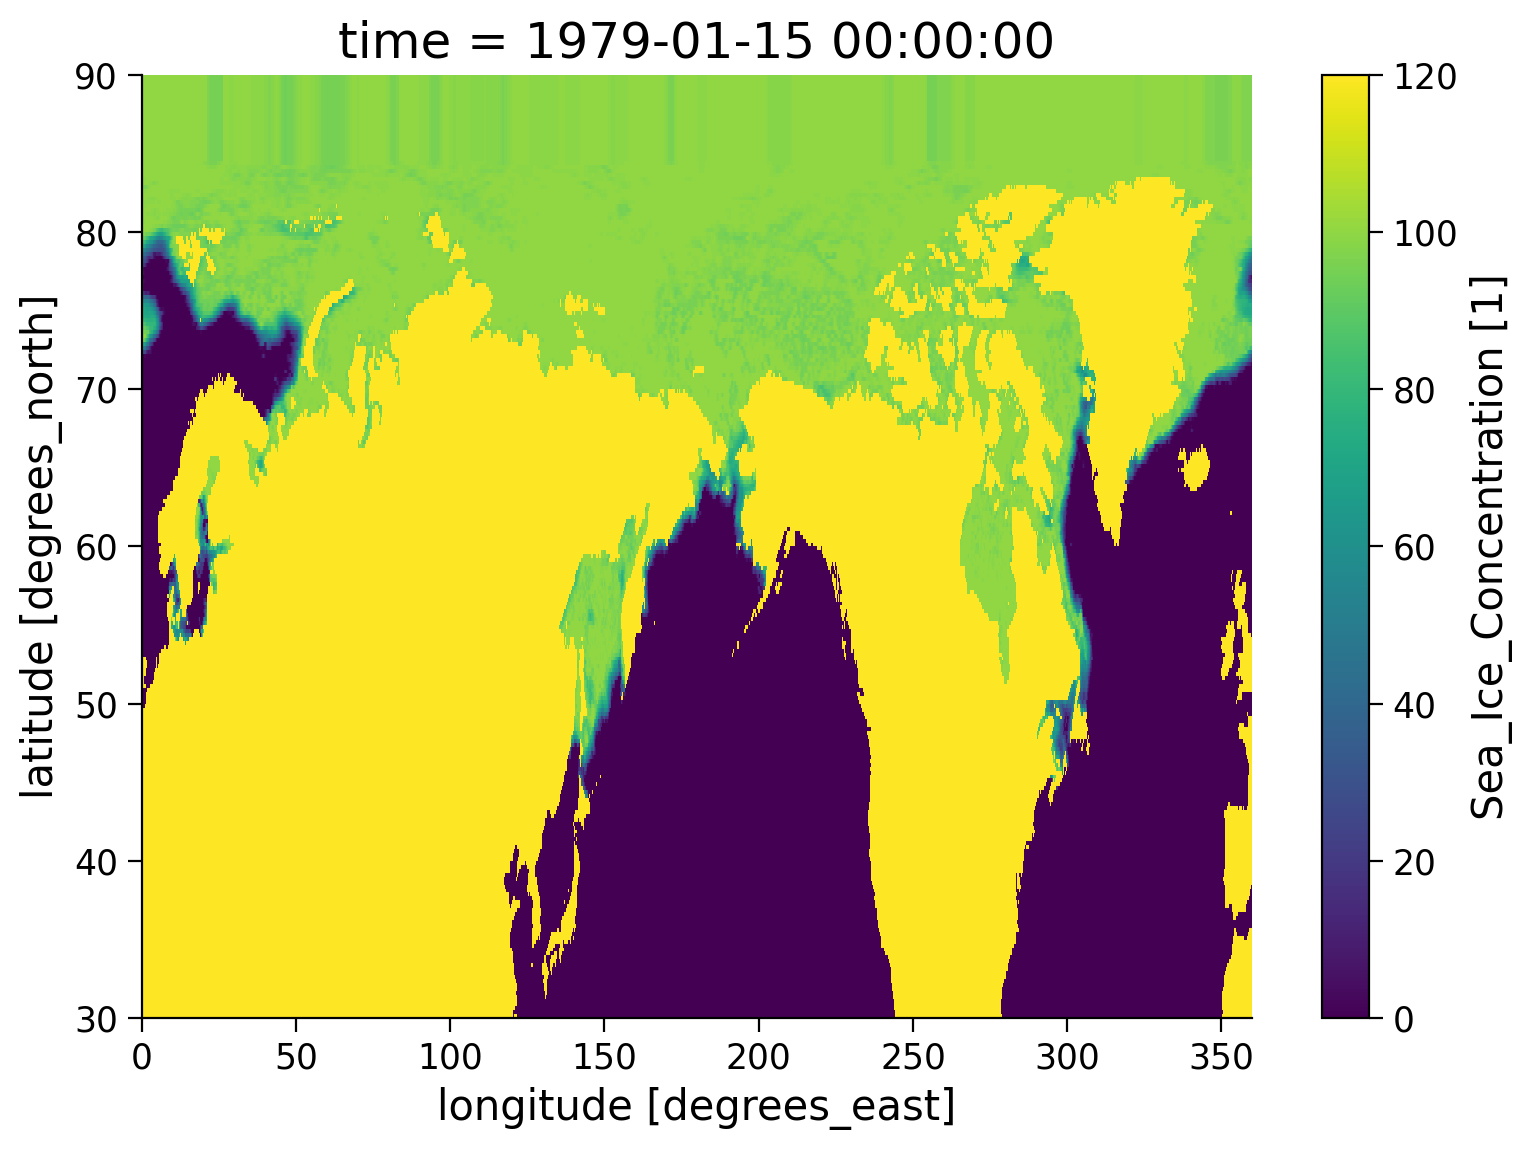

In [ ]:
# We can select and plot the first month
# using .isel(time=0) and inbuilt xarray plotting,
# just to check the data looks reasonable:
SI_obs_ds.isel(time=0).seaice_conc.plot()

Note that the dataset also includes variables for grid cell area and given in $\text{km}^2$.

We will need this to convert the spatial data into a time series of the total Arctic sea ice area.

The code below shows how this can be done:

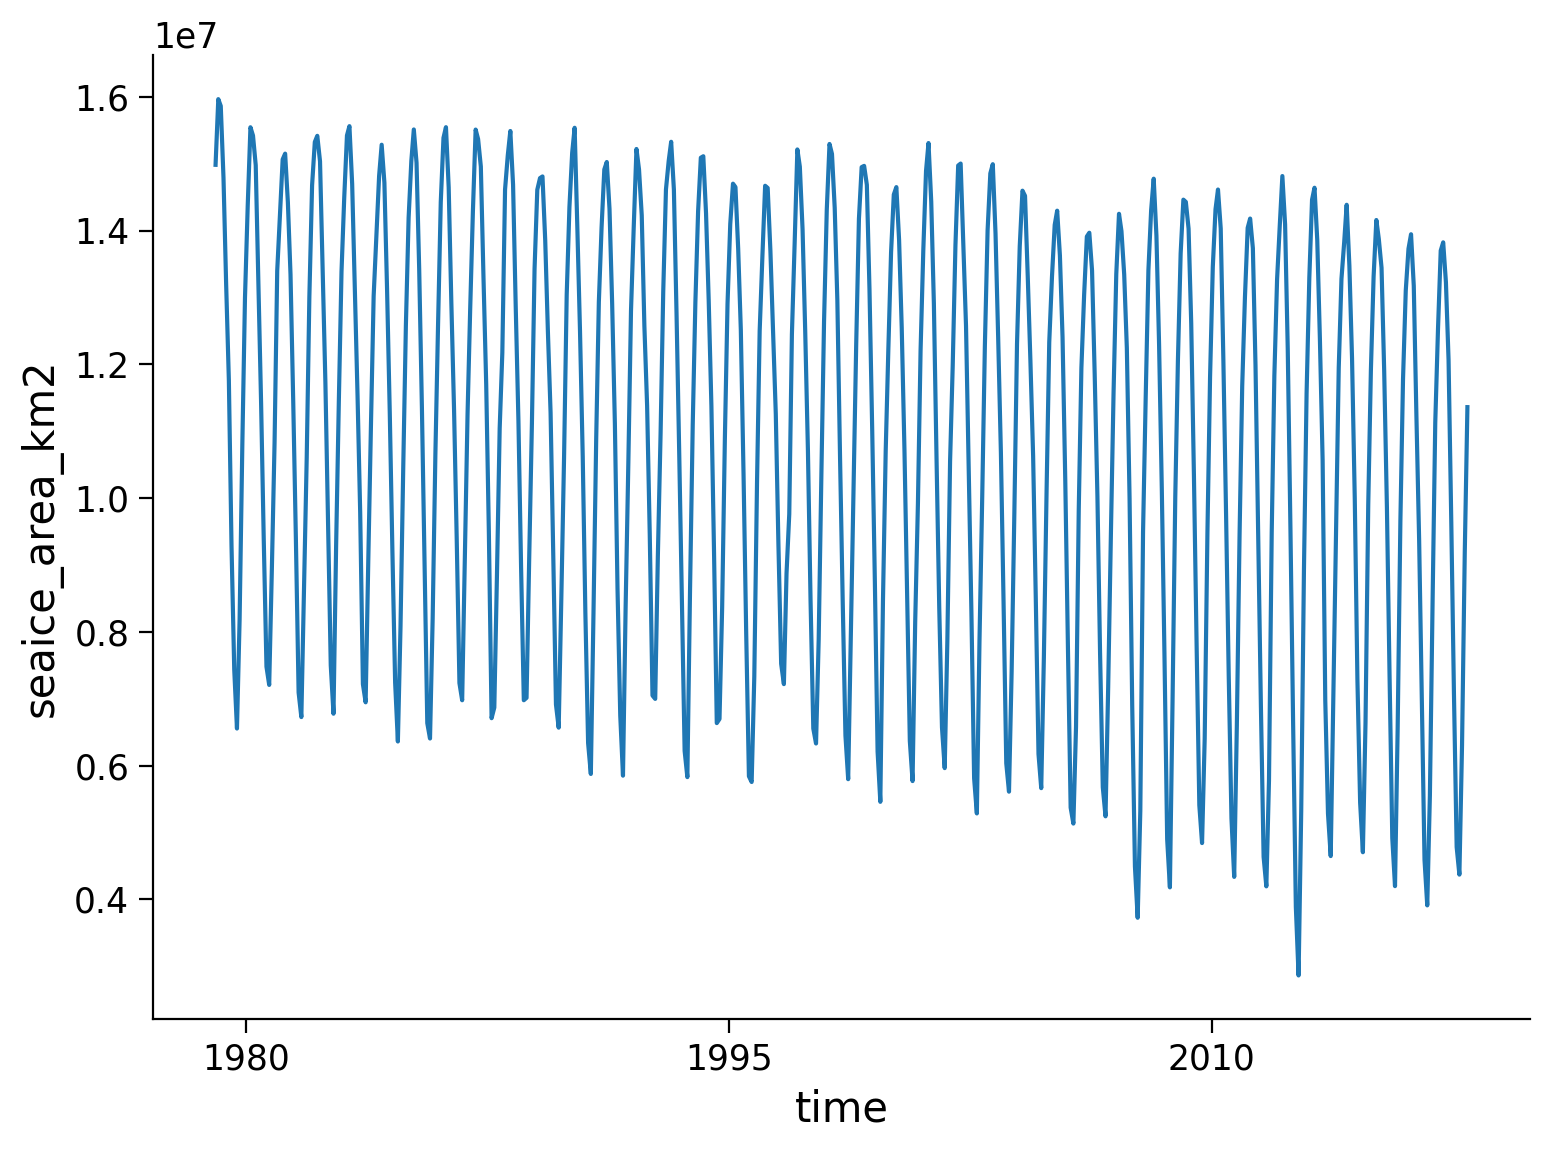

In [ ]:
# select only the ocean regions by ignoring any percentages over 100:
SI_obs_ds = SI_obs_ds.where(SI_obs_ds['seaice_conc'] < 101)

# then multiply the ice fraction in each grid cell by the cell area:
# factor of 0.01 servees to convert from percentage to fraction
SI_obs_ds['seaice_area_km2'] = 0.01 * SI_obs_ds['seaice_conc'] * SI_obs_ds['Gridcell_Area']

# finally, we can sum this sea ice area variable over the spatial dimensions to get
# a time series of total Arctic sea ice area:
SI_total_area_obs = SI_obs_ds['seaice_area_km2'].sum(dim=['latitude', 'longitude'])
SI_total_area_obs.plot()

Now you can add the observational decline of sea ice to your analysis if you wish!

In [ ]:
#hii
a = 2
b = 1
print(a+b)

3
